In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

def read_fsr_data_from_excel(file_path, sheet_name=0):
    """
    Read FSR data from Excel file
    Expected format: 
    - Column A: WEIGHT values
    - Columns B, D, F, etc.: FSR ADC values (FSR1_ADC, FSR2_ADC, etc.)
    - Columns C, E, G, etc.: FSR Error values (FSR1_Error, FSR2_Error, etc.)
    """
    try:
        # Read Excel file
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Get weight column (assuming it's the first column)
        weights = df.iloc[:, 0].dropna().tolist()
        
        # Initialize dictionary to store FSR data
        fsr_data = {}
        
        # Process columns in pairs (ADC, Error)
        for i in range(1, len(df.columns), 2):
            if i+1 < len(df.columns):
                # Get column names
                adc_col = df.columns[i]
                error_col = df.columns[i+1]
                
                # Extract FSR name from column header (e.g., "FSR1_ADC" -> "FSR1")
                if '_ADC' in adc_col:
                    fsr_name = adc_col.split('_')[0]
                elif 'FSR' in adc_col:
                    # Handle different naming conventions
                    fsr_name = adc_col.replace('_ADC', '').replace(' ADC', '')
                else:
                    fsr_name = f"FSR{(i+1)//2}"
                
                # Get ADC values and errors, removing NaN values
                adc_values = df[adc_col].dropna().tolist()
                adc_errors = df[error_col].dropna().tolist()
                
                # Ensure all lists have the same length
                min_length = min(len(weights), len(adc_values), len(adc_errors))
                
                fsr_data[fsr_name] = {
                    'weights': weights[:min_length],
                    'adc_values': adc_values[:min_length],
                    'adc_errors': adc_errors[:min_length]
                }
        
        print(f"Successfully loaded data for {len(fsr_data)} FSR sensors")
        print(f"Available FSRs: {list(fsr_data.keys())}")
        return fsr_data
        
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

def exp_func(y, a, b):
    """Exponential function for curve fitting"""
    return np.exp((y - b) / a)

def analyze_fsr(fsr_name, fsr_data=None):
    """Analyze individual FSR sensor data"""
    
    # If no fsr_data provided, try to use global variable or load from default file
    if fsr_data is None:
        try:
            # Try to use global fsr_data if it exists
            global_fsr_data = globals().get('fsr_data')
            if global_fsr_data is not None:
                fsr_data = global_fsr_data
            else:
                print("No FSR data provided. Please load data first using:")
                print("fsr_data = read_fsr_data_from_excel('your_file.xlsx')")
                return None
        except:
            print("Error: No FSR data available.")
            return None
    
    if fsr_name not in fsr_data:
        print(f"Error: {fsr_name} not found in the database.")
        print(f"Available FSRs: {list(fsr_data.keys())}")
        return None
    
    # Get the data for this FSR
    data = fsr_data[fsr_name]
    weights = np.array(data['weights'])
    adc_values = np.array(data['adc_values'])
    adc_errors = np.array(data['adc_errors'])
    
    # Fit the exponential model
    try:
        params, covariance = curve_fit(exp_func, adc_values, weights, 
                                      p0=[1700, 19700])  # Initial guess
        a_fit, b_fit = params
    except RuntimeError as e:
        print(f"Error fitting curve: {e}")
        return None
    
    # Generate points for plotting
    adc_range = np.linspace(min(adc_values)*0.98, max(adc_values)*1.02, 200)
    weight_pred = exp_func(adc_range, a_fit, b_fit)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Add error bars to the scatter points
    plt.errorbar(weights, adc_values, yerr=adc_errors, fmt='o', color='blue',
                 ecolor='black', capsize=5, markersize=6, label='Data with errors')
    
    # Plot the fitted curve
    plt.plot(weight_pred, adc_range, 'r--', 
             label=f'WEIGHT = exp((ADC - {b_fit:.1f}) / {a_fit:.1f})')
    
    # Add percentage error annotations
    for x, y, err in zip(weights, adc_values, adc_errors):
        percent_error = (err / y) * 100
        plt.text(x, y + err + 100, f"{percent_error:.1f}%", fontsize=9,
                 color='darkgreen', ha='center')
    
    # Calculate R² for the model
    residuals = weights - exp_func(adc_values, a_fit, b_fit)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((weights - np.mean(weights))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    plt.plot([], [], ' ', label=f'R² = {r_squared:.4f}')
    
    # Add grid, labels, and title
    plt.grid(True)
    plt.xlabel('WEIGHT (kg)', fontsize=12)
    plt.ylabel('ADC', fontsize=12)
    plt.title(fsr_name, fontsize=14)
    plt.legend()
    plt.xlim(0, 5)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Print model information
    print(f"{fsr_name} model: Cân nặng = exp((ADC - {b_fit:.2f}) / {a_fit:.2f})")
    print(f"R² score: {r_squared:.6f}")
    
    # Create table of predicted values
    test_adc = np.array([17000, 18000, 19000, 20000, 21000, 22000])
    predicted_weights = exp_func(test_adc, a_fit, b_fit)
    
    print("\nPredicted values:")
    for adc, weight in zip(test_adc, predicted_weights):
        print(f"ADC: {adc:.2f} → Cân nặng: {weight:.4f} kg")
    
    # Return the model parameters and function for reuse
    return {
        'a': a_fit,
        'b': b_fit,
        'r_squared': r_squared,
        'predict_function': lambda adc: exp_func(adc, a_fit, b_fit)
    }

def analyze_all_fsrs(fsr_data, save_results=False):
   
    results = {}
    
    for fsr_name in fsr_data.keys():
        print(f"\n{'='*50}")
        print(f"Analyzing {fsr_name}")
        print('='*50)
        
        result = analyze_fsr(fsr_name, fsr_data)
        if result:
            results[fsr_name] = result
    
    if save_results and results:
       
        summary_data = []
        for fsr_name, result in results.items():
            summary_data.append({
                'FSR': fsr_name,
                'Parameter_a': result['a'],
                'Parameter_b': result['b'],
                'R_squared': result['r_squared'],
                'Equation': f"exp((ADC - {result['b']:.2f}) / {result['a']:.2f})"
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel('fsr_analysis_results.xlsx', index=False)
        print(f"\nResults saved to 'fsr_analysis_results.xlsx'")
    
    return results

In [17]:
# Load data từ Excel
excel_file_path = 'system.xlsx'  # Thay bằng đường dẫn file của bạn
fsr_data = read_fsr_data_from_excel(excel_file_path)


Successfully loaded data for 10 FSR sensors
Available FSRs: ['FSR1', 'FSR2', 'FSR3', 'FSR4', 'FSR5', 'FSR6', 'FSR7', 'FSR8', 'FSR9', 'FSR10']


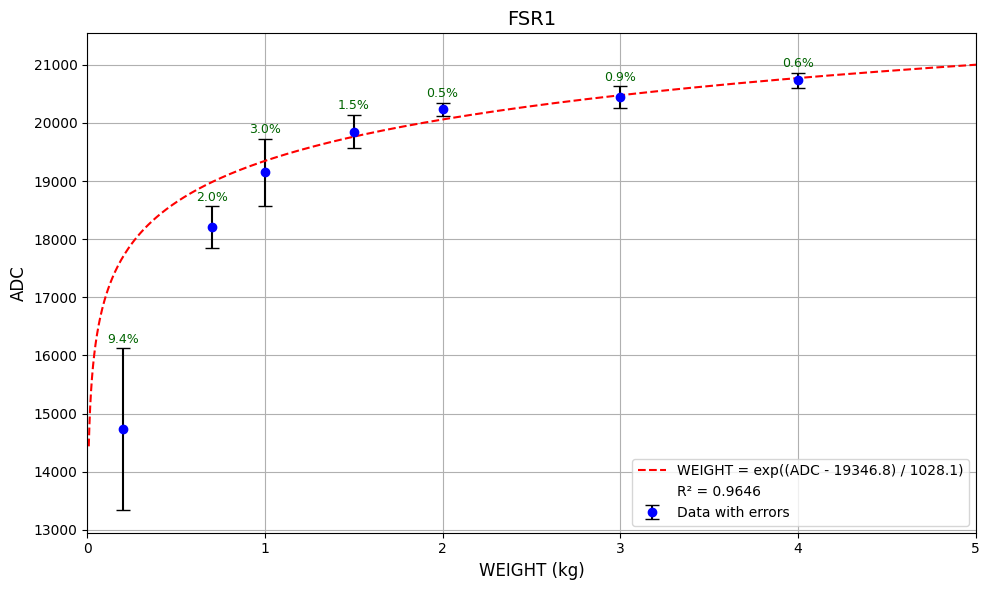

FSR1 model: Cân nặng = exp((ADC - 19346.84) / 1028.05)
R² score: 0.964647

Predicted values:
ADC: 17000.00 → Cân nặng: 0.1020 kg
ADC: 18000.00 → Cân nặng: 0.2698 kg
ADC: 19000.00 → Cân nặng: 0.7136 kg
ADC: 20000.00 → Cân nặng: 1.8877 kg
ADC: 21000.00 → Cân nặng: 4.9931 kg
ADC: 22000.00 → Cân nặng: 13.2072 kg


In [18]:
# Analyze FSR1 và lấy model
fsr1_model = analyze_fsr('FSR1')

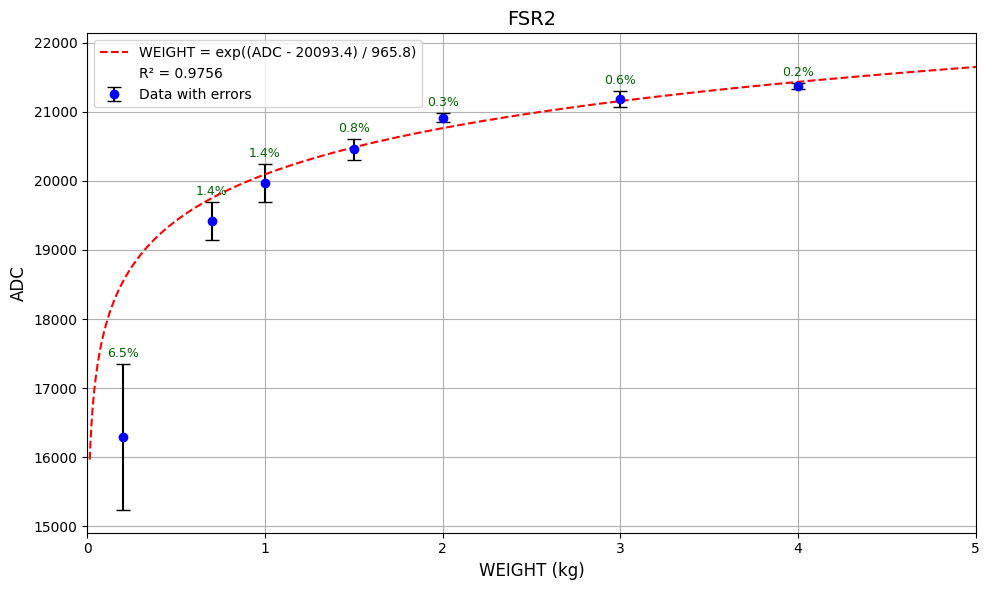

FSR2 model: Cân nặng = exp((ADC - 20093.40) / 965.77)
R² score: 0.975569

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0406 kg
ADC: 18000.00 → Cân nặng: 0.1145 kg
ADC: 19000.00 → Cân nặng: 0.3223 kg
ADC: 20000.00 → Cân nặng: 0.9078 kg
ADC: 21000.00 → Cân nặng: 2.5567 kg
ADC: 22000.00 → Cân nặng: 7.2006 kg


In [19]:
fsr2_model = analyze_fsr('FSR2')

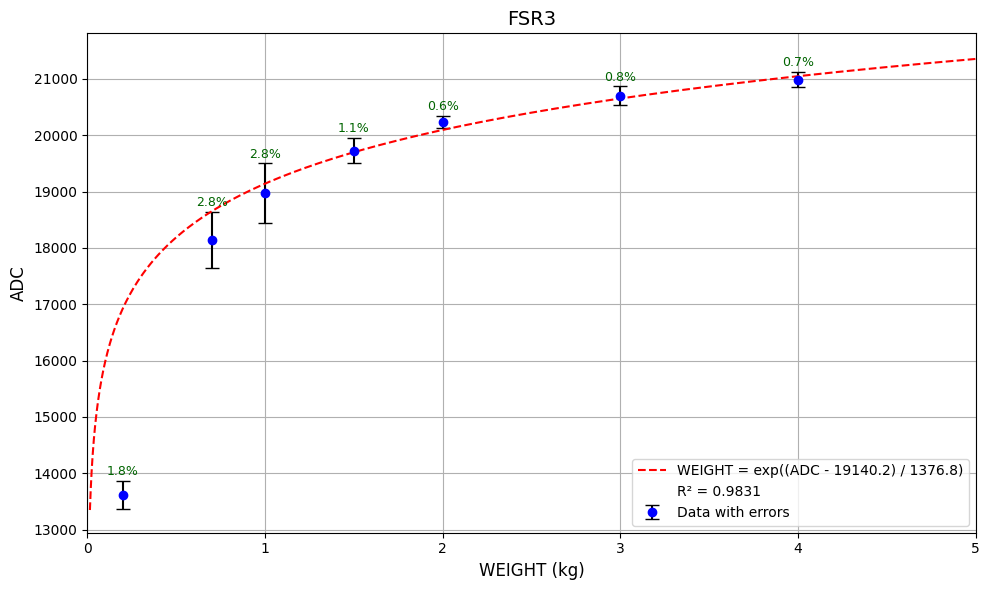

FSR3 model: Cân nặng = exp((ADC - 19140.22) / 1376.81)
R² score: 0.983083

Predicted values:
ADC: 17000.00 → Cân nặng: 0.2113 kg
ADC: 18000.00 → Cân nặng: 0.4369 kg
ADC: 19000.00 → Cân nặng: 0.9032 kg
ADC: 20000.00 → Cân nặng: 1.8673 kg
ADC: 21000.00 → Cân nặng: 3.8605 kg
ADC: 22000.00 → Cân nặng: 7.9813 kg


In [20]:
fsr3_model = analyze_fsr('FSR3')

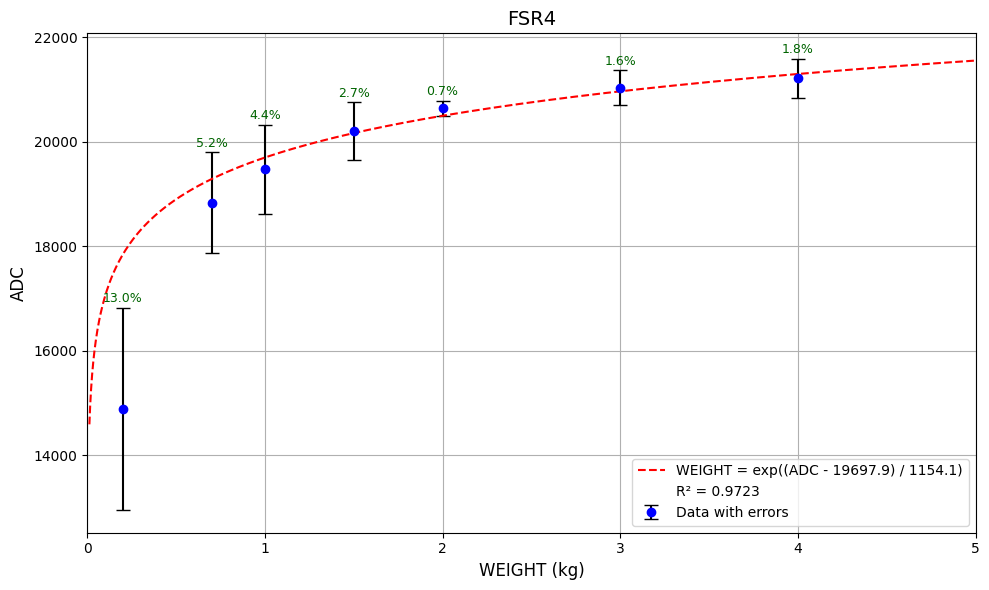

FSR4 model: Cân nặng = exp((ADC - 19697.95) / 1154.06)
R² score: 0.972315

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0965 kg
ADC: 18000.00 → Cân nặng: 0.2296 kg
ADC: 19000.00 → Cân nặng: 0.5462 kg
ADC: 20000.00 → Cân nặng: 1.2992 kg
ADC: 21000.00 → Cân nặng: 3.0902 kg
ADC: 22000.00 → Cân nặng: 7.3503 kg


In [21]:
fsr4_model = analyze_fsr('FSR4')

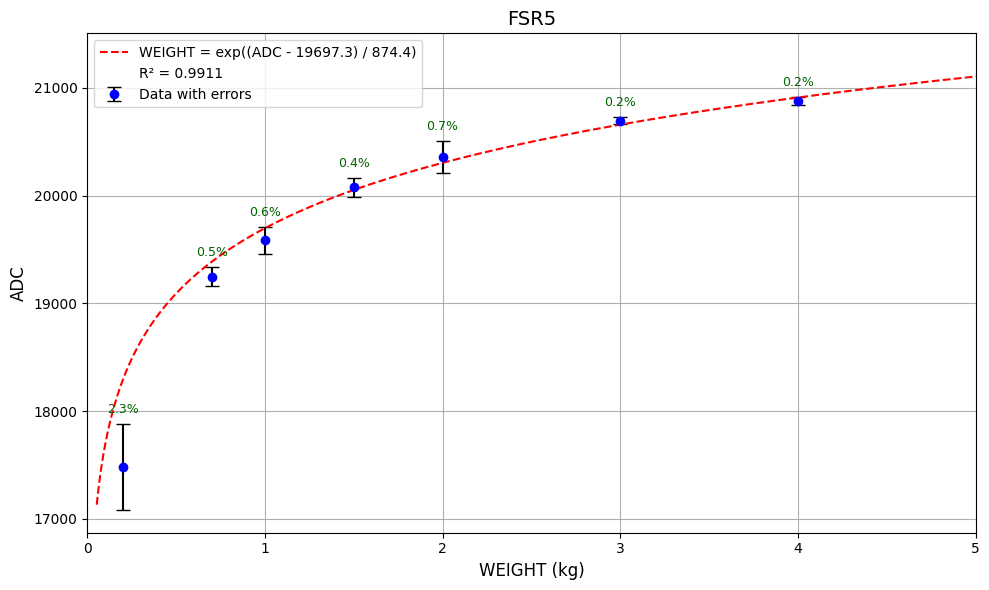

FSR5 model: Cân nặng = exp((ADC - 19697.33) / 874.39)
R² score: 0.991065

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0457 kg
ADC: 18000.00 → Cân nặng: 0.1435 kg
ADC: 19000.00 → Cân nặng: 0.4505 kg
ADC: 20000.00 → Cân nặng: 1.4136 kg
ADC: 21000.00 → Cân nặng: 4.4362 kg
ADC: 22000.00 → Cân nặng: 13.9218 kg


In [22]:
fsr5_model = analyze_fsr('FSR5')

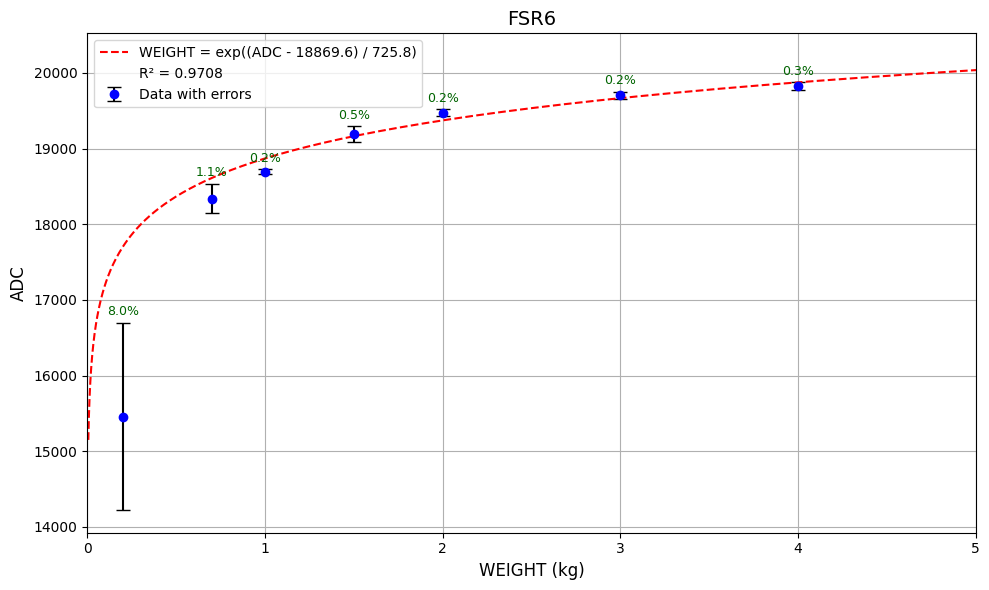

FSR6 model: Cân nặng = exp((ADC - 18869.61) / 725.78)
R² score: 0.970805

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0761 kg
ADC: 18000.00 → Cân nặng: 0.3017 kg
ADC: 19000.00 → Cân nặng: 1.1968 kg
ADC: 20000.00 → Cân nặng: 4.7469 kg
ADC: 21000.00 → Cân nặng: 18.8277 kg
ADC: 22000.00 → Cân nặng: 74.6763 kg


In [23]:
fsr6_model = analyze_fsr('FSR6')

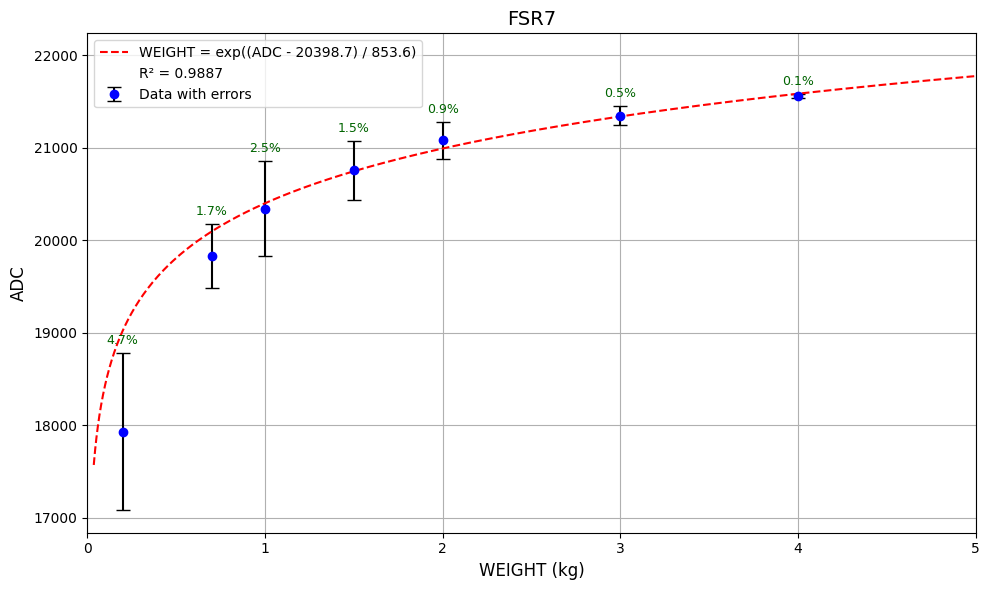

FSR7 model: Cân nặng = exp((ADC - 20398.71) / 853.61)
R² score: 0.988740

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0187 kg
ADC: 18000.00 → Cân nặng: 0.0602 kg
ADC: 19000.00 → Cân nặng: 0.1943 kg
ADC: 20000.00 → Cân nặng: 0.6268 kg
ADC: 21000.00 → Cân nặng: 2.0227 kg
ADC: 22000.00 → Cân nặng: 6.5268 kg


In [24]:
fsr7_model = analyze_fsr('FSR7')

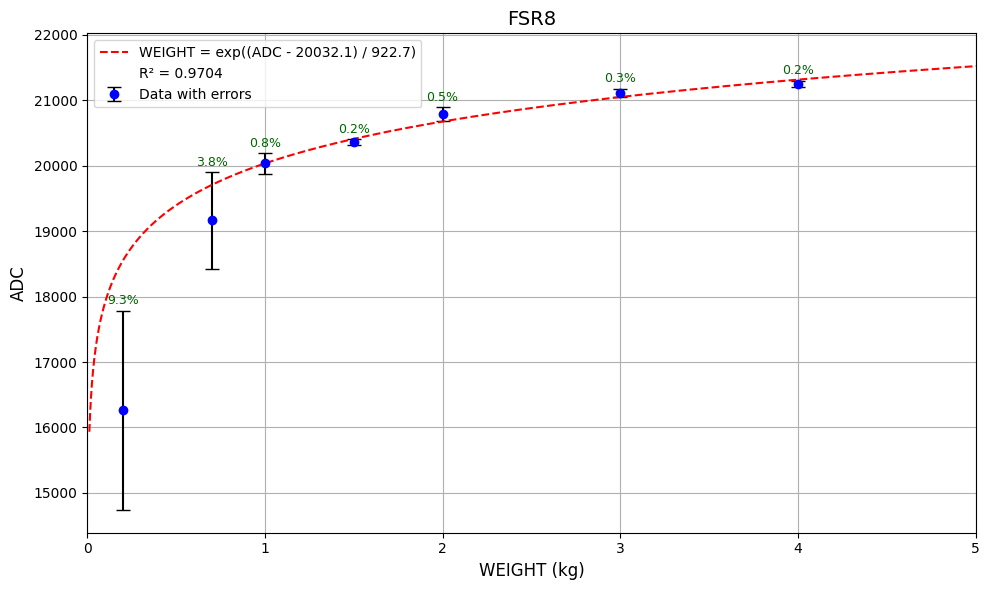

FSR8 model: Cân nặng = exp((ADC - 20032.10) / 922.72)
R² score: 0.970449

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0374 kg
ADC: 18000.00 → Cân nặng: 0.1106 kg
ADC: 19000.00 → Cân nặng: 0.3268 kg
ADC: 20000.00 → Cân nặng: 0.9658 kg
ADC: 21000.00 → Cân nặng: 2.8547 kg
ADC: 22000.00 → Cân nặng: 8.4377 kg


In [25]:
fsr8_model = analyze_fsr('FSR8')

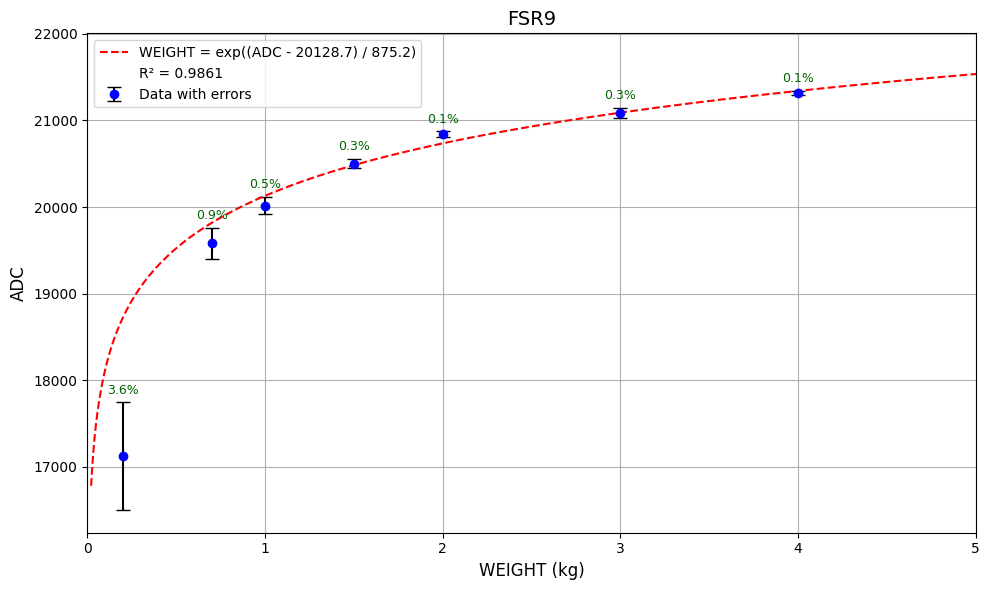

FSR9 model: Cân nặng = exp((ADC - 20128.72) / 875.15)
R² score: 0.986086

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0280 kg
ADC: 18000.00 → Cân nặng: 0.0878 kg
ADC: 19000.00 → Cân nặng: 0.2753 kg
ADC: 20000.00 → Cân nặng: 0.8632 kg
ADC: 21000.00 → Cân nặng: 2.7063 kg
ADC: 22000.00 → Cân nặng: 8.4845 kg


In [26]:
fsr9_model = analyze_fsr('FSR9')

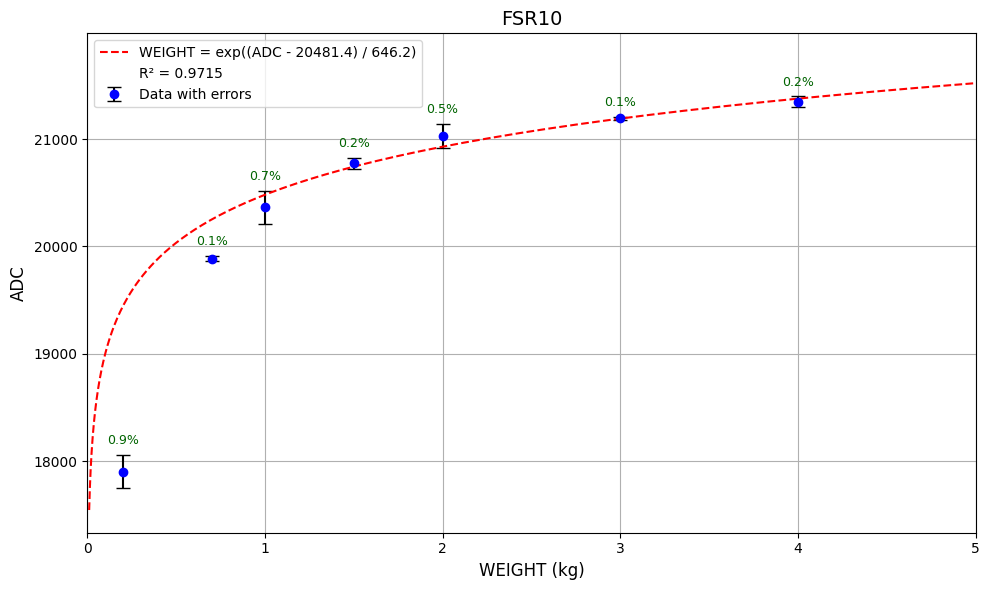

FSR10 model: Cân nặng = exp((ADC - 20481.41) / 646.23)
R² score: 0.971507

Predicted values:
ADC: 17000.00 → Cân nặng: 0.0046 kg
ADC: 18000.00 → Cân nặng: 0.0215 kg
ADC: 19000.00 → Cân nặng: 0.1010 kg
ADC: 20000.00 → Cân nặng: 0.4748 kg
ADC: 21000.00 → Cân nặng: 2.2311 kg
ADC: 22000.00 → Cân nặng: 10.4848 kg


In [27]:
fsr10_model = analyze_fsr('FSR10')